### To Do / License

- Use TimesFM to make predictions
- Highlight no training needed
- Highlight covariants
- We can predict the Brand Awareness Marketing Campaign
  - Generate pass history of pass sales with covariants
  - Predict at the Truck, User level?
- Save data to table in BigQuery
- Draw meaningful charts and graphs

```
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

Author: Adam Paternostro

### Readme


- Run this on a e2-standard-8 machine with 250 GB of disk.
- A GPU is not required for testing purposes in this notebook.
- You can deploy TimesFM via the Vertex Model Garden utilizing a GPU.

### TimesFM - Overview

- View GitHub repository: [Link](https://github.com/google-research/timesfm/)
- TimesFM is a "State-of-the-Art Large Language Models". These are the most advanced and powerful language models currently available.
- TimesFM supports univariate time-series forecasting
  - This is like trying to predict what the temperature will be tomorrow, based only on the past temperature data. We're not looking at other factors like rainfall or humidity, just the temperature itself. It's like saying, "Based on how the temperature has changed in the past, what's my best guess for tomorrow?"
- TimesFM also supports Covariate/Multivariate support
  - Now imagine we want to improve our predictions by considering other factors that might influence the temperature, like rainfall or humidity. That's where covariate/multivariate support comes in. It's like saying, "Okay, I know past temperatures are important, but what if I also looked at past rainfall and humidity to make my prediction even better?"
    - Covariates: These are the additional factors (like rainfall and humidity) that we think might influence the thing we're trying to predict. They're like sidekicks helping us make a more informed guess.
    - Multivariate: This just means we're now dealing with multiple variables (temperature, rainfall, humidity) instead of just one.
  So with covariate/multivariate support, our forecasting model gets smarter. It can learn how changes in rainfall or humidity tend to affect the temperature, and use that information to make more accurate predictions. It's like having a team of experts working together to solve a puzzle, instead of just one person trying to figure it out alone.
  - Notebook with covariates ([link](https://github.com/google-research/timesfm/blob/master/notebooks/covariates.ipynb))
- Decoder-only patched-transformer architecture
  - This is getting into the technical nuts and bolts of how the model is built.
  - "Transformer" is a type of neural network architecture that has become very popular for language tasks.
  - "Decoder-only" means it's specifically designed for generating text (like in translation or writing tasks), not for understanding and analyzing existing text.
  - "Patched" likely refers to some modifications made to the basic transformer design to make it more efficient or better suited to the specific task.
- Can handle different context and horizon length
  - "Context" refers to the surrounding information the model uses to make predictions. So, this model can work with varying amounts of context, from short sentences to longer passages.
  - "Horizon length" is how far into the future the model is trying to predict. This design can handle both short-term and longer-term predictions.
- Fast inference due to patching
  - "Inference" is the process of using the model to make predictions.
  - The "patching" mentioned earlier helps make this process faster. This is important for real-world applications where you need quick responses.


### Tutorial: Sales Forecast (Marketing Campaign, Day of Week, Temperature)


#### Example Scenerio

In [7]:
# We want to predict our coffee sales based upon past sales, past marketing campaigns and the temperature.

# Let's view our example data.
# We have 2 weeks of existings sales data (columns C through P)
#   For the sales data we know:
#      1. If a marketing campaign was taking place
#      2. The day of the week (maybe weekends are busier?)
#      3. The temperature (maywe we sell more on cold days that hot?)
# We have the price and item name which are "static"

# We want to predict the next 1 week of sales data
#   We need to provide if we will be running a marketing campaign, the temperature (so get the next weeks weather data) and the day of the week
#   We can then run our prediction

from IPython.display import Image
Image(url='https://storage.googleapis.com/data-analytics-golden-demo/chocolate-ai/v2/artifacts/chocolate-ai-TimesFM.png', width=1200)

- See this Google Sheet for the data ([link](https://docs.google.com/spreadsheets/d/1kutd-R2PAj26nZGnCAHPGK8MyFWZMnStA2yzki4q60o/edit?gid=0#gid=0))

In [8]:
# To read/write to/from Kafka
import sys

# https://PLACEHOLDER.com/index.html

# For better performance and production, deploy to Vertex AI endpoint with GPU
# This takes about 5 minutes to install and you will need to reset your runtime
!{sys.executable} -m pip install timesfm

In [9]:
import timesfm

#### Configure TimesFM

In [10]:
print(timesfm.TimesFm.__doc__)

TimesFM forecast API for inference.

  This class is the scaffolding for calling TimesFM forecast. To properly use:
    1. Create an instance with the correct hyperparameters of a TimesFM model.
    2. Call `load_from_checkpoint` to load a compatible checkpoint.
    3. Call `forecast` for inference.

  Given the model size, this API does not shard the model weights for SPMD. All
  parallelism happens on the data dimension.

  Compilation happens during the first time `forecast` is called and uses the
  `per_core_batch_size` to set and freeze the input signature. Subsequent calls
  to `forecast` reflect the actual inference latency.

  Attributes:
    per_core_batch_size: Batch size on each core for data parallelism.
    backend: One of "cpu", "gpu" or "tpu".
    num_devices: Number of cores provided the backend.
    global_batch_size: per_core_batch_size * num_devices. Each batch of
      inference task will be padded with respect to global_batch_size to
      minimize latency.
    con

In [11]:
timesfm_backend = "cpu" # "cpu": "cpu", "gpu": "cuda", "tpu": ""

from jax._src import config
config.update("jax_platforms", timesfm_backend)

model = timesfm.TimesFm(
    context_len=512,
    horizon_len=7, # Predict next 7 days, this could be 128 without requiring compute (129 would be a step up).  This is more of the max horizon len.
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",
)

# This can produce "ERROR:absl:For checkpoint version > 1.0, we require users to provide", you can ignore that
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 5.73 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.76 seconds.
Jitting decoding.
Jitted decoding in 32.35 seconds.


#### Run the Prediction

In [12]:
print(model.forecast_with_covariates.__doc__)

Forecasts on a list of time series with covariates.

    To optimize inference speed, avoid string valued categorical covariates.

    Args:
      inputs: A list of time series forecast contexts. Each context time series
        should be in a format convertible to JTensor by `jnp.array`.
      dynamic_numerical_covariates: A dict of dynamic numerical covariates.
      dynamic_categorical_covariates: A dict of dynamic categorical covariates.
      static_numerical_covariates: A dict of static numerical covariates.
      static_categorical_covariates: A dict of static categorical covariates.
      freq: frequency of each context time series. 0 for high frequency
        (default), 1 for medium, and 2 for low. Notice this is different from
        the `freq` required by `forecast_on_df`.
      window_size: window size of trend + residual decomposition. If None then
        we do not do decomposition.
      forecast_context_len: optional max context length.
      xreg_mode: one of "xreg +

In [13]:
# This is our sales data, 2 weeks of data for cafe-mocha
inputs = [[100,105,125,133,145,107,156,101,106,105,105,104,136,165]]

# These are our categorical covariates (additional factors that we think might influence the thing we're trying to predict).
# Here we consider the day of the week and if a marketing campaign was in progress
dynamic_categorical_covariates = {
    "day_of_week": [[1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7]],
    "marketing_campaign": [["N","N","Y","Y","Y","N","N","N","N","N","N","N","Y","N","N","Y","N","N","N","N","N"]]
}

# These are our numerical covariates (additional numeric factors, just like the categories, but numbers)
# Here we consider the temperature of the day
dynamic_numerical_covariates = {
    "temperature": [[90,90,90,90,90,90,100,90,90,90,90,90,90,100,90,90,90,90,90,100,90]]
}

# These are our static covariates (additional factors that we think are fixed, like the price of the product)
# Here we consider the price of the product
static_numerical_covariates = {
    "price": [7.95]
}

# These are our static categorical covariates (additional factors that we think are fixed, like the menu item)
# Here we consider the menu item
static_categorical_covariates = {
    "menu_item" : ["cafe-mocha"]
}

# frequency of each context time series. 0 for high frequency (default), 1 for medium, and 2 for low.
frequency = [0]

model_forecast, xreg_forecast = model.forecast_with_covariates(
    inputs=inputs,
    dynamic_categorical_covariates=dynamic_categorical_covariates,
    dynamic_numerical_covariates=dynamic_numerical_covariates,
    static_numerical_covariates=static_numerical_covariates,
    static_categorical_covariates=static_categorical_covariates,
    freq=frequency,
    xreg_mode="xreg + timesfm",              # default
    ridge=0.0,
    force_on_cpu=False,
    normalize_xreg_target_per_input=True,    # default
)

In [14]:
# See the next 7 days of forecasted values
model_forecast[0]

array([101.25364 , 134.18452 , 100.36569 , 105.38627 , 110.12915 ,
       161.58717 , 105.469734], dtype=float32)

#### Visualize the results

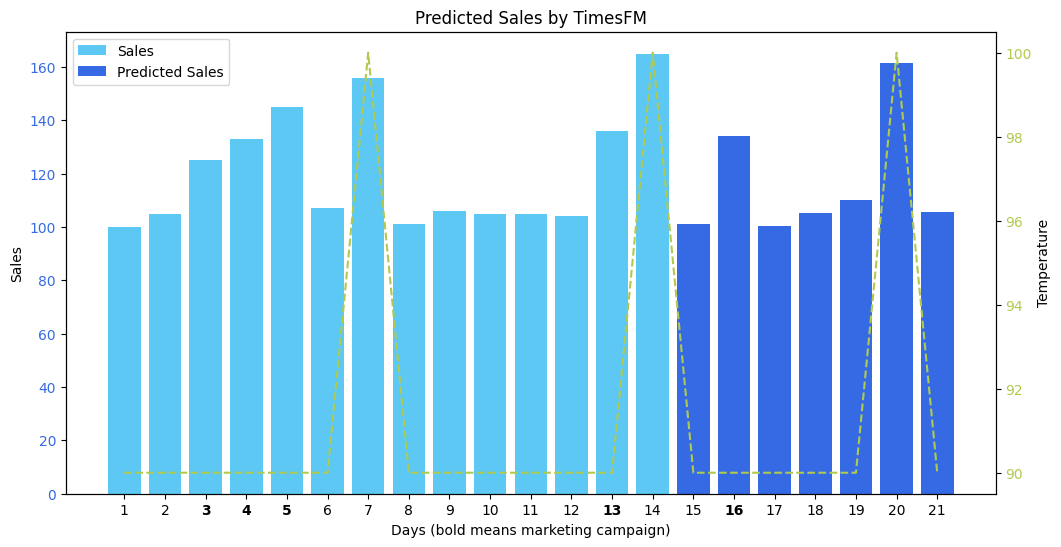

In [15]:
import matplotlib.pyplot as plt

# Data
sales = inputs[0]
predicted_sales = model_forecast[0]
marketing_campaigns = dynamic_categorical_covariates["marketing_campaign"]
temperature = dynamic_numerical_covariates["temperature"][0]

# Create x-axis values
all_days = list(range(1, 22))  # Days as integers from 1 to 21
days = list(range(1, 15))  # Adjust range if needed
days_predicted = list(range(15, 22))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sales as a bar chart
ax1.bar(days, sales, color='#{:02x}{:02x}{:02x}'.format(92, 200, 243), label='Sales')

# Plot predicted sales as a bar chart
ax1.bar(days_predicted, predicted_sales, color='#{:02x}{:02x}{:02x}'.format(53, 106, 228), label='Predicted Sales')

# Set x-axis ticks and labels for all days
ax1.set_xticks(all_days)
ax1.set_xticklabels(all_days)

ax1.set_xlabel('Days (bold means marketing campaign)')
ax1.set_ylabel('Sales', color="black")
ax1.tick_params(axis='y', labelcolor='#{:02x}{:02x}{:02x}'.format(53, 106, 228))

# Create a second y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(all_days, temperature, color='#{:02x}{:02x}{:02x}'.format(176, 202, 78), linestyle = '--', alpha = 1)
ax2.set_ylabel('Temperature', color="black")
ax2.tick_params(axis='y', labelcolor='#{:02x}{:02x}{:02x}'.format(176, 202, 78))

# Add marketing campaign indicators (bold the "days" when we had a marketing campaign)
for i, campaign in enumerate(marketing_campaigns[0]):
  if campaign == 'Y':
    ax1.get_xticklabels()[i].set_weight('bold')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.title('Predicted Sales by TimesFM')
plt.show()

### Marketing Campaign Forecast

- Take into account the segments
- Take into account the channels
- Day of week?
- Click through rate?
- Data
  - Sales by person
  - What type of campaign was running
  - How we know they purchased based upon a campaign (coupon, app?)
  -